<div style="vertical-align:middle">
<img width="170" style="float: right;" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />
<h1>Modelos compactos para sistemas empotrados<a id="top"></a></h1>
<i><small>Fuentes: <a href="https://github.com/etsisi/Robotica">github.com/etsisi/Robotica</a><br>Última actualización: 2023-10-21</i>
</div>
<hr>

## Introducción

El aprendizaje automático (ML, del inglés _Machine Learning_) ha encontrado aplicaciones en una amplia variedad de campos, revolucionando la forma en que se resuelven los problemas y se toman decisiones. Sin embargo, la mayoría de las aplicaciones de ML tradicionales dependen de grandes infraestructuras (local o en la nube) para el entrenamiento y la inferencia. En contraste, TinyML se refiere a la práctica de ejecutar modelos de aprendizaje automático en dispositivos de borde (<i>edge computing</i>) con recursos limitados, como microcontroladores.

La ventaja de TinyML radica en su capacidad para llevar la inteligencia de la máquina directamente a los dispositivos de borde, permitiendo la inferencia en tiempo real con baja latencia y preservación de la privacidad, ya que los datos no necesitan ser transmitidos a un servidor central para su procesamiento. Además, TinyML puede operar en condiciones de conectividad limitada o nula, lo cual es crucial en muchos escenarios del mundo real.

### Objetivos

El propósito de este notebook es proporcionar una comprensión práctica del flujo de trabajo involucrado en un proyecto TinyML. Los objetivos específicos incluyen:

1. **Entendimiento del Proceso de Creación del Modelo:** Lo cual ya hemos explorado en los anteriores <i>notebooks</i>,
2. **Conversión del Modelo a TensorFlow Lite:** Convertir el modelo entrenado a un formato que pueda ser ejecutado en microcontroladores usando TensorFlow Lite.
3. **Cuantización del Modelo:**, Explorar la cuantización del modelo para reducir el tamaño del modelo, lo cual es vital para la implementación en determinados dispositivos con recursos limitados.

Al final de este notebook, deberías tener una comprensión clara de cómo se puede desarrollar un modelo de aprendizaje automático, convertirlo para su uso en microcontroladores, y optimizar su tamaño a través de la cuantización, facilitando así su implementación en dispositivos de borde.

## Bibliotecas y configuración

Comenzaremos instalando las bibliotecas necesarias. Esto sólo es necesario en el caso de que no tengamos el entorno ya creado.

In [ ]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install tensorflow

A continuación importaremos las bibliotecas que se utilizarán a lo largo del notebook.

In [1]:
import os
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

2023-10-19 09:40:37.366826: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-19 09:40:37.403092: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-19 09:40:37.403120: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-19 09:40:37.403142: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-19 09:40:37.409529: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-19 09:40:37.410490: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Forzamos algunos parámetros de configuración

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

os.environ["CUDA_VISIBLE_DEVICES"] = ""  # Usar CPU

***

## Preparación del conjunto de datos

Ya conocemos el conjunto de datos MNIST. Ahora procederemos a:

1. Cargar conjuntos de datos de entrenamiento y test,
2. Normalizar valores de entrada al intervalo $[0, 1]$,
3. Añadir una nueva dimensión que represente el único canal de color porque vamos a usar una red convolucional.

No transformaremos las etiquetas del dataset ya que usaremos la versión _sparse_ del _loss_ de la entropía cruzada.

In [3]:
# Descarga de datos
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Normalización
x_train, x_test = x_train / 255.0, x_test / 255.0
# Nueva dimensión
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]

print(f'Dimensiones entrenamiento: {x_train.shape} input, {y_train.shape} output')
print(f'Dimensiones test:          {x_test.shape} input, {y_test.shape} output')

11490434/11490434 [==============================] - 2s 0us/step
Dimensiones entrenamiento: (60000, 28, 28, 1) input, (60000,) output
Dimensiones test:          (10000, 28, 28, 1) input, (10000,) output


## Modelo de predicción

Crearemos una red de convolución normal similar a la del anterior ejemplo, usando para ellos capas de convolución, _pooling_, _flatten_ y densas. Aprovecharemos la función `create_model` para devolver el modelo ya compilado.

In [4]:
def create_model():
    # Creación del grafo que representa a la red
    input = tf.keras.Input(shape=(28, 28, 1))
    output = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input)
    output = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(output)
    output = tf.keras.layers.MaxPooling2D((2, 2))(output)
    output = tf.keras.layers.Flatten()(output)
    output = tf.keras.layers.Dropout(0.5)(output)
    output = tf.keras.layers.Dense(10, activation='softmax')(output)
    # Modelo que especifica qué nodos del grafo son los de entrada y de salida
    model = tf.keras.Model(input, output)
    # Compilación del modelo
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )
    
    return model 

model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                             

Ahora entrenaremos el modelo durante 10 epochs para que esté ajustado al problema. Esta vez usaremos un split del conjunto de validación un poco más pequeño y un tamaño de batch más grande.

In [5]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
1688/1688 [==============================] - 41s 24ms/step - loss: 0.1965 - sparse_categorical_accuracy: 0.9405 - val_loss: 0.0618 - val_sparse_categorical_accuracy: 0.9817
Epoch 2/10
1688/1688 [==============================] - 40s 24ms/step - loss: 0.0799 - sparse_categorical_accuracy: 0.9762 - val_loss: 0.0557 - val_sparse_categorical_accuracy: 0.9848
Epoch 3/10
1688/1688 [==============================] - 41s 24ms/step - loss: 0.0641 - sparse_categorical_accuracy: 0.9795 - val_loss: 0.0523 - val_sparse_categorical_accuracy: 0.9842
Epoch 4/10
1688/1688 [==============================] - 40s 24ms/step - loss: 0.0546 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.0436 - val_sparse_categorical_accuracy: 0.9873
Epoch 5/10
1688/1688 [==============================] - 41s 24ms/step - loss: 0.0459 - sparse_categorical_accuracy: 0.9857 - val_loss: 0.0427 - val_sparse_categorical_accuracy: 0.9887
Epoch 6/10
1688/1688 [==============================] - 41s 24ms/step - loss: 0.

Veamos cómo ha progresado el entrenamiento.

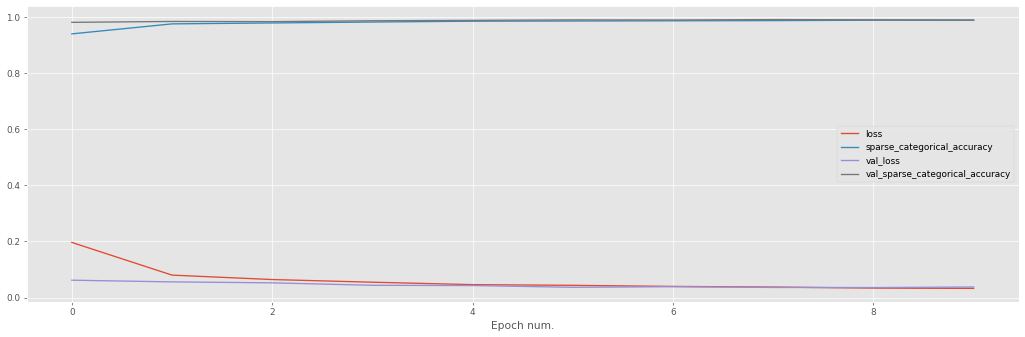

In [6]:
pd.DataFrame(history.history).plot()
plt.xlabel('Epoch num.')
plt.show()

Independientemente de lo bueno o malo que parezca, vamos a seguir con este modelo.

Antes de nada salvaremos el modelo a fichero para realizar comparativas; para ello usaremos el método `save` del propio modelo. Antiguamente el formato de salvado era el HDF5. De hecho se puede seguir usando, aunque se considera _legacy_ y en algún momento desaparecerá de la biblioteca.

El formato actual, `.keras`, es un fichero zip que contiene la arquitectura (fichero `config.json`), los pesos (fichero `model.weights.h5`) y demás metainformación (fichero `metadata.json`) del modelo. Esto nos permite, entre otros, salvar y cargar el modelo en estadios intermedios de un entrenamiento, por ejemplo.

In [7]:
BASE_MODEL = 'base_model.keras'

model.save(BASE_MODEL)

Veamos el contenido del fichero y cuánto ocupa.

In [9]:
print(f'Tamaño de "{BASE_MODEL}": {os.path.getsize(BASE_MODEL) / 1024:.5} KiB')
zip = zipfile.ZipFile(BASE_MODEL)
print(f'Contenidos del fichero:  {zip.namelist()}')

Tamaño de "base_model.keras": 686.83 KiB
Contenidos del fichero:  ['metadata.json', 'config.json', 'model.weights.h5']


## Conversión a TFLite

El primer paso para convertir un modelo entrenado de TensorFlow (vale, en keras, pero usando como _backend_ TensorFlow) es la creación del objeto convertidor de la clase `TFLiteConverter`. Este objeto será el responsable de llevar a cabo la conversión del modelo.

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

Ahora podemos proceder a converir el modelo a formato TFLite.

In [11]:
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpj691ada5/assets


INFO:tensorflow:Assets written to: /tmp/tmpj691ada5/assets
2023-10-19 09:56:10.995314: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-19 09:56:10.995333: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-10-19 09:56:10.996171: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpj691ada5
2023-10-19 09:56:10.997401: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-10-19 09:56:10.997410: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpj691ada5
2023-10-19 09:56:11.000101: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-10-19 09:56:11.000978: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-10-19 09:56:11.046687: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

En este paso, ejecutamos la conversión del modelo utilizando el método `convert` del objeto convertidor. Esto genera un modelo en formato TFLite que es adecuado para ejecutarse en dispositivos como microcontroladores.

Este objeto se puede salvar a fichero trabajando como con cualquier objeto binario.

In [12]:
TFLITE_MODEL = 'tfl_model.tflite'

with open(TFLITE_MODEL, 'wb') as f:
    f.write(tflite_model)

Veamos la diferencia en tamañode ambos ficheros.

In [14]:
for file in (BASE_MODEL, TFLITE_MODEL):
    print(f'{file}: {os.path.getsize(file) / 1024:.5} KiB')

base_model.keras: 686.83 KiB
tfl_model.tflite: 220.05 KiB


Bueno, más de un $50\%$ de reducción, bastante bien.

## Cuantización del modelo

La cuantización es un proceso que puede reducir significativamente tanto el tamaño del modelo como el tiempo de ejecución, con una pequeña pérdida en la precisión. Esto es especialmente útil en el contexto de TinyML, donde los recursos son limitados.

Existen varias opciones de cuantización. Aquí nos centraremos en dos de tipo **post-entrenamiento** ofrecidas por TFLite. La **cuantización consciente del entrenamiento** o QAT (del inglés _Quantization Aware Training_) se basa en simular la cuantización de los pesos y activaciones durante el entrenamiento; de esta manera el modelo aprende a compensar la pérdida de precisión que ocurre durante la cuantización, resultando en un modelo cuantizado con una precisión mucho más cercana al modelo original de punto flotante. Sin embargo este proceso es más complejo y va más allá del alcance de este _notebook_.

La cuantización **post-entrenamiento** es un proceso que convierte los los valores de punto flotante a valores enteros después del entrenamiento. Esto puede reducir el tamaño del modelo y mejorar el rendimiento sin necesidad de reentrenar el modelo.

### Cuantización estática

Convierte los pesos del modelo y de las funciones de activación de punto flotante a valores enteros después del entrenamiento. Esto generalmente reduce el tamaño del modelo y mejora su rendimiento, aunque a costa de una pérdida de precisión.

Se configura a través de un parámetro de optimización (`Optimize.DEFAULT`) del converter. Crearemos un nuevo fichero con el modelo comprimido con esta configuración.

In [15]:
TFLITE_STATIC_QUANT_MODEL = 'tsq_model.tflite'

# Creación del convertidor y configuración
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convertimos el modelo
tflite_static_quant_model = converter.convert()

# Salvado a fichero
with open(TFLITE_STATIC_QUANT_MODEL, 'wb') as f:
    f.write(tflite_static_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmp9ume1obr/assets


INFO:tensorflow:Assets written to: /tmp/tmp9ume1obr/assets
2023-10-19 10:00:50.198567: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-19 10:00:50.198584: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-10-19 10:00:50.198811: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp9ume1obr
2023-10-19 10:00:50.200157: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-10-19 10:00:50.200168: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp9ume1obr
2023-10-19 10:00:50.203249: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-10-19 10:00:50.242630: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp9ume1obr
2023-10-19 10:00:50.256543: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

### Cuantización dinámica

Convierte los pesos a enteros pero mantiene las activaciones en punto flotante. Esto es útil para ciertos modelos y puede proporcionar un equilibrio entre tamaño, rendimiento y precisión.

Al igual que con la estática, la dinámica se configura a través de un parámetro de optimización (`Optimize.OPTIMIZE_FOR_LATENCY`) del converter. Crearemos también un fichero con esta configuración.

In [16]:
TFLITE_DYNAMIC_QUANT_MODEL = 'tdq_model.tflite'

# Creación del convertidor y configuración
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]

# Convertimos el modelo
tflite_dynamic_quant_model = converter.convert()

# Salvado a fichero
with open(TFLITE_DYNAMIC_QUANT_MODEL, 'wb') as f:
    f.write(tflite_dynamic_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmphag5639i/assets


INFO:tensorflow:Assets written to: /tmp/tmphag5639i/assets
2023-10-19 10:00:53.600949: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-19 10:00:53.600983: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-10-19 10:00:53.601358: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmphag5639i
2023-10-19 10:00:53.603745: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-10-19 10:00:53.603767: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmphag5639i
2023-10-19 10:00:53.610434: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-10-19 10:00:53.666632: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmphag5639i
2023-10-19 10:00:53.679566: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

### Comparación de espacio en disco

A continuación se muestra el tamaño ocupado por cada uno de los diferentes ficheros de modelo.

In [17]:
for file in (
    BASE_MODEL,
    TFLITE_MODEL,
    TFLITE_STATIC_QUANT_MODEL,
    TFLITE_DYNAMIC_QUANT_MODEL,
): 
    print(f'{file}: {os.path.getsize(file) / 1024:.6} KiB')

base_model.keras: 686.827 KiB
tfl_model.tflite: 220.055 KiB
tsq_model.tflite: 58.5391 KiB
tdq_model.tflite: 58.5391 KiB


Curiosamente el modelo es el mismo (o al menos equivalente en tamaño) en las dos versiones cuantizadas. Eso sí, ocupan $10$ veces menos que el modelo original, lo cual es un gran logro.

## Conclusiones

Hemos navegado por los distintos pasos involucrados en la preparación y optimización de un modelo de aprendizaje automático para dispositivos de borde bajo el paradigma de TinyML. Los puntos clave obtenidos son los siguientes:

- Un buen dataset y una buena arquitectura son cruciales para el éxito del proyecto. Un modelo bien entrenado y validado es el punto de partida para cualquier proyecto TinyML.
- La conversión del modelo a TensorFlow Lite es un paso esencial para preparar el modelo para su ejecución en microcontroladores. Es de fácil implementación haciendo uso de convertidores, los cuales nos transforman un modelo de TensorFlow a un formato compatible con dispositivos _de frontera_.
- La cuantización es una técnica muy valiosa para reducir el tamaño del modelo y acelerar la inferencia, lo que es crucial para el desempeño en dispositivos con recursos limitados. Exploramos la cuantización post-entrenamiento, que es una forma eficaz y sencilla de cuantizar un modelo sin la necesidad de reentrenamiento.

Este proyecto proporciona una base sólida para explorar más a fondo cómo TinyML puede desbloquear nuevas capacidades en dispositivos de _edge computing_ y cómo podemos continuar optimizando y desplegando modelos de aprendizaje automático en hardware con recursos limitados.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>